# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [0]:
import pandas as pd
import numpy as np
import io
from matplotlib import pyplot as plt



## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

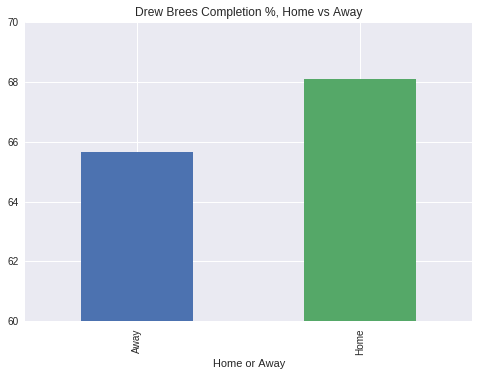

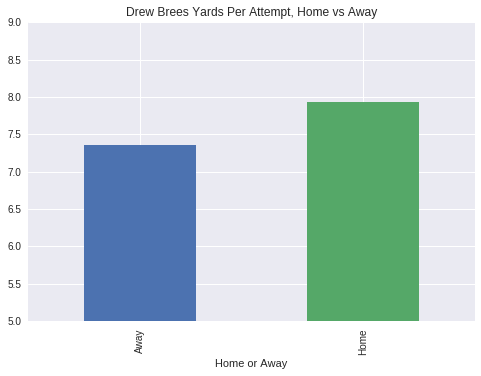

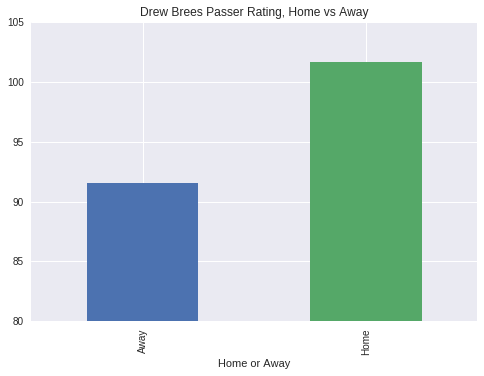

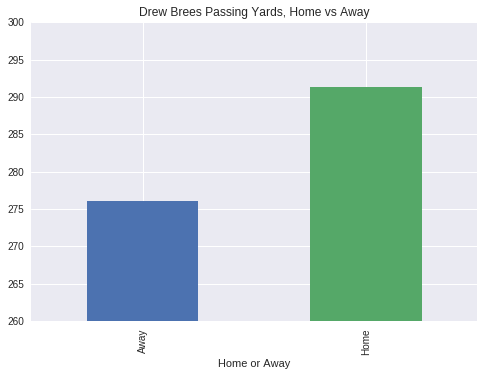

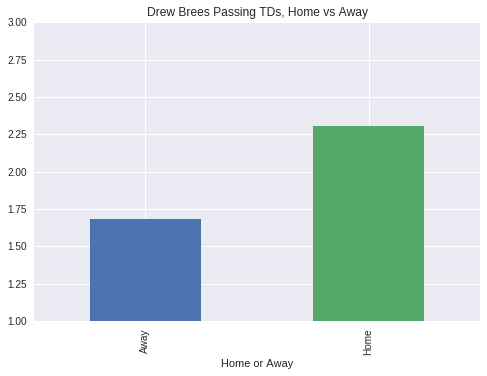

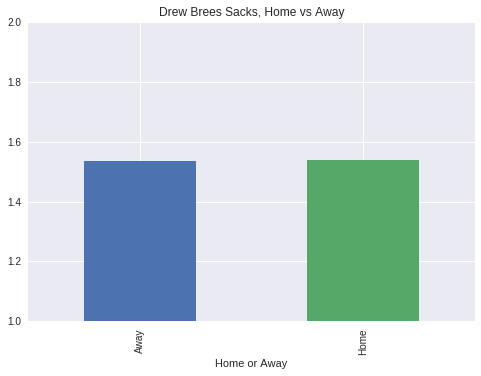

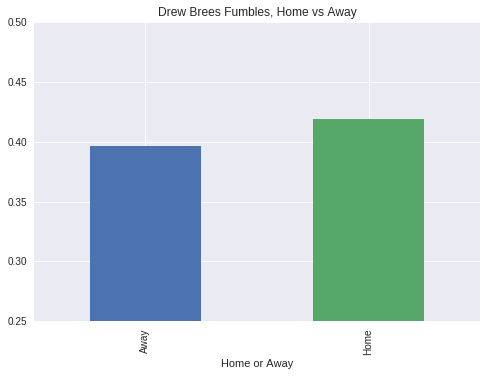

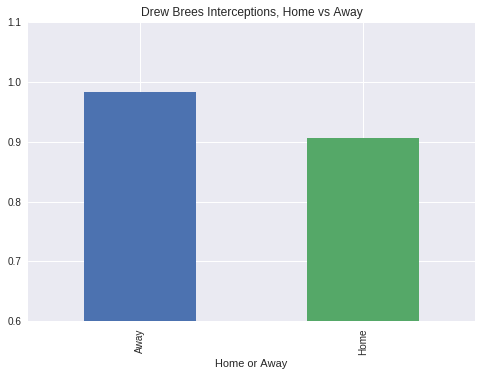

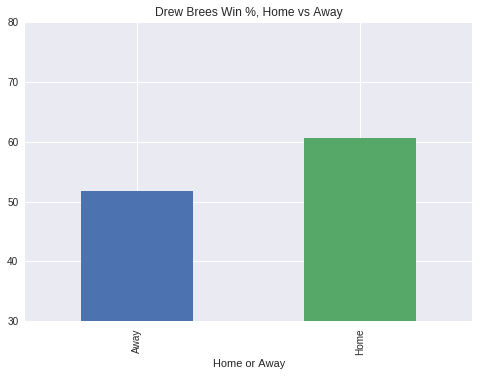

In [160]:
df = pd.read_csv('https://raw.githubusercontent.com/Nolanole/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module1-afirstlookatdata/Game_Logs_Quarterback.csv')

brees = df[(df['Player Id'] == 'drewbrees/2504775') & (df['Season'] == 'Regular Season')]

#Efficiency Stats (Completion % / YPA / Rating )
efficiency = brees[['Home or Away', 'Completion Percentage', 'Passing Yards Per Attempt', 'Passer Rating']]
efficiency = efficiency[efficiency['Passing Yards Per Attempt'] != '--']
efficiency['Passing Yards Per Attempt'] = efficiency['Passing Yards Per Attempt'].astype('float')
efficiency['Completion Percentage'] = efficiency['Completion Percentage'].astype('float')


#Production (Yards / TDs)

production = brees[['Home or Away', 'Passing Yards', 'TD Passes']]
production = production[production['Passing Yards'] != '--']
production['Passing Yards'] = production['Passing Yards'] .astype('float')
production['TD Passes'] = production['TD Passes'].astype('float')


#Negative Plays/Mistakes (Sacks / Fumbles / INTs)

mistakes = brees[['Home or Away', 'Sacks', 'Fumbles', 'Ints']]
mistakes = mistakes[mistakes['Sacks'] != '--']
mistakes.replace(to_replace='--', value = 0, inplace=True)
mistakes['Sacks'] = mistakes['Sacks'].astype('float')
mistakes['Fumbles'] = mistakes['Fumbles'].astype('float')
mistakes['Ints'] = mistakes['Ints'].astype('float')


#Wins/Losses

win_loss = brees[['Home or Away', 'Outcome', 'Passing Yards Per Attempt']]
#First drop the games he didnt play in
win_loss = win_loss[win_loss['Passing Yards Per Attempt'] != '--']
#remove passing ypa column
win_loss.drop('Passing Yards Per Attempt', axis=1, inplace=True)

#replace categorical w numeric data (binary)
win_loss['Outcome'].replace(to_replace = 'W', value = 1, inplace=True)
win_loss['Outcome'].replace(to_replace = 'L', value = 0, inplace=True)


#Plots:
#Efficiency Metrics
comp_percentage = efficiency.groupby('Home or Away')['Completion Percentage'].mean()
comp_percentage.plot(kind='bar', ylim=(60, 70), title="Drew Brees Completion %, Home vs Away")
plt.show()
ypa = efficiency.groupby('Home or Away')['Passing Yards Per Attempt'].mean()
ypa.plot(kind='bar', ylim=(5,9), title="Drew Brees Yards Per Attempt, Home vs Away")
plt.show()
rating = efficiency.groupby('Home or Away')['Passer Rating'].mean()
rating.plot(kind='bar', ylim=(80,105), title="Drew Brees Passer Rating, Home vs Away")
plt.show()

#Production Metrics
yards = production.groupby('Home or Away')['Passing Yards'].mean()
yards.plot(kind='bar', ylim=(260, 300), title="Drew Brees Passing Yards, Home vs Away")
plt.show()
tds = production.groupby('Home or Away')['TD Passes'].mean()
tds.plot(kind='bar', ylim=(1,3), title="Drew Brees Passing TDs, Home vs Away")
plt.show()

#Mistake Metrics
sacks = mistakes.groupby('Home or Away')['Sacks'].mean()
sacks.plot(kind='bar', ylim=(1,2), title="Drew Brees Sacks, Home vs Away")
plt.show()
fumbles = mistakes.groupby('Home or Away')['Fumbles'].mean()
fumbles.plot(kind='bar', ylim=(.25, .5), title="Drew Brees Fumbles, Home vs Away")
plt.show()
ints = mistakes.groupby('Home or Away')['Ints'].mean()
ints.plot(kind='bar', ylim=(.6, 1.1), title="Drew Brees Interceptions, Home vs Away")
plt.show()

#Wins vs Losses
wins = win_loss.groupby('Home or Away')['Outcome'].mean()
wins = wins*100
wins.plot(kind='bar', ylim=(30,80), title="Drew Brees Win %, Home vs Away")
plt.show()





### Assignment questions
'''
After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.
Today I found some nfl statistics data on kaggle, and decided to hone in on the avail data for Drew Brees, QB for my hometown fav team New Orleans Saints. In football circles, Brees is regarded as a much better QB at home vs on the road, so I wanted to dive in to his statistics a little bit to see how significant the differences were. I uploaded the csv file to github, read it into a pandas dataframe, and then divided the dataframe into a few smaller dataframes based on diff categories of the data. First, I wanted to see how his efficency metrics differed at home vs away, so I used completion  %, yards per attempt, and QB rating. Next I looked at raw passing production, using passing yards and TDs. Next I looked at negative plays/mistakes, looking at sacks, fumbles, and interceptions. Finally I looked at overll win-loss %. I used matplotlib and created charts for all of these metrics.

2.  What was the most challenging part of what you did?
I would say the most difficult roadblock actually had a pretty simple solution. I had difficuly figuring out how to upload my csv file from my hard drive to the jupyter notebook. The first solution I found required me to re-upload it everytime the notebook cell was executed. After seeking help in Slack i learned about how to upload the csv file to github and link to the raw data with pandas read_csv.

3.  What was the most interesting thing you learned?
The data required a decent amount of cleanup. Overall the most interesting things I learned was just struggling with the data, converting columns from string dtypes to float, dropping rows w/ missing values, and converting categorical data to numeric binary data for computational purposes.

4.  What area would you like to explore with more time?
I definitely need more time working with matplotlib. I ran out of time today, but definitely have a lot to learn in order to improve my graph/chart skills.



## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.